In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

<h3><b>SQL Server Data Extraction</b></h3>

In [3]:
pip install sqlalchemy pyodbc pandas

Note: you may need to restart the kernel to use updated packages.


In [4]:
from sqlalchemy import create_engine
import pandas as pd

server = 'LAPTOP-174FML7C\\SQLEXPRESS' 
database = 'INSTANT'

engine = create_engine(f"mssql+pyodbc://@{server}/{database}?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server")

tables = ['users_data', 'transactions_data', 'cards_data']

dfs = {}

for table in tables:
    dfs[table] = pd.read_sql_table(table, engine)

engine.dispose()

<h3><b>Loading SQL Server Tables into Pandas DataFrames</b></h3>

In [6]:
users_df = dfs['users_data']
transactions_df = dfs['transactions_data']
cards_df = dfs['cards_data']

In [7]:
users_df.head()

,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,0,33,69,1986,3,Male,858 Plum Avenue,43.590000,-70.330002,29237.0,59613.0,36199.0,763,4
1,1,43,74,1976,4,Female,113 Burns Lane,30.440001,-87.180000,22247.0,45360.0,14587.0,704,3
2,2,48,64,1971,8,Male,6035 Forest Avenue,40.840000,-73.870003,13461.0,27447.0,80850.0,673,5
3,3,49,65,1970,12,Male,840 Elm Avenue,33.889999,-98.510002,13705.0,27943.0,18693.0,681,4
4,4,54,72,1965,3,Female,6016 Little Creek Boulevard,47.610001,-122.300003,37485.0,76431.0,115362.0,716,5


In [8]:
transactions_df.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,
3,7475331,2010-01-01 00:05:00,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,
4,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,


In [9]:
cards_df.head()

,id,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,0,1362,Amex,Credit,393314135668401,04/2024,866,True,2,33900.0,01/1991,2014,No
1,1,550,Mastercard,Credit,5278231764792292,06/2024,396,True,1,11600.0,01/1994,2013,No
2,2,556,Mastercard,Debit,5889825928297675,09/2021,422,True,1,19948.0,01/1995,2011,No
3,3,1937,Visa,Credit,4289888672554714,04/2020,736,True,2,16400.0,01/1995,2015,No
4,4,1981,Mastercard,Debit,5433366978583845,03/2024,530,True,2,19439.0,01/1997,2007,No


<h4><b>Load MCC Codes JSON & Merge into Transactions</b></h4>

In [11]:
import json
import pandas as pd

# Load MCC codes JSON
with open('data/Finance/mcc_codes.json', 'r') as f:
    mcc_dict = json.load(f)

# Map MCC descriptions
transactions_df['mcc_description'] = transactions_df['mcc'].map(mcc_dict)

transactions_df.to_csv("transactions_with_mcc.csv", index=False)
transactions_df.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,mcc_description
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,,Miscellaneous Food Stores
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,,Department Stores
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,,Money Transfer
3,7475331,2010-01-01 00:05:00,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,,Money Transfer
4,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,,Drinking Places (Alcoholic Beverages)


<h4><b>Load fraud labels JSON & Merge into Transactions</b></h4>

In [13]:
with open('data/Finance/train_fraud_labels.json', 'r') as f:
    data = json.load(f)

# Extract the "target" dictionary
fraud_dict = data["target"]

# Convert to DataFrame
fraud_df = pd.DataFrame(list(fraud_dict.items()), columns=['id', 'fraud_label'])

# Convert id to int and add numeric fraud flag
fraud_df['id'] = fraud_df['id'].astype(int)

# Save to CSV
fraud_df.to_csv("fraud_labels.csv", index=False)

# Merge with transactions data on 'id'
transactions_df = transactions_df.merge(fraud_df, on='id', how='left')
transactions_df.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,mcc_description,fraud_label
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,,Miscellaneous Food Stores,No
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,,Department Stores,No
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,,Money Transfer,No
3,7475331,2010-01-01 00:05:00,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,,Money Transfer,NaN
4,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,,Drinking Places (Alcoholic Beverages),No


<h3><b>Data Overview<b></h3>

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

<h4><b>1. Users Data</b></h4>

In [17]:
# Structure Overview
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2000 non-null   int64  
 1   current_age        2000 non-null   int64  
 2   retirement_age     2000 non-null   int64  
 3   birth_year         2000 non-null   int64  
 4   birth_month        2000 non-null   int64  
 5   gender             2000 non-null   object 
 6   address            2000 non-null   object 
 7   latitude           2000 non-null   float64
 8   longitude          2000 non-null   float64
 9   per_capita_income  2000 non-null   float64
 10  yearly_income      2000 non-null   float64
 11  total_debt         2000 non-null   float64
 12  credit_score       2000 non-null   int64  
 13  num_credit_cards   2000 non-null   int64  
dtypes: float64(5), int64(7), object(2)
memory usage: 218.9+ KB


In [18]:
# Descriptive Statistics
users_df.describe()

,id,current_age,retirement_age,birth_year,birth_month,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,999.500000,45.391500,66.237500,1973.803000,6.439000,37.389225,-91.554765,23141.928000,45715.882000,63709.694000,709.734500,3.073000
std,577.494589,18.414092,3.628867,18.421234,3.565338,5.114324,16.283293,11324.137358,22992.615456,52254.453421,67.221949,1.637379
min,0.000000,18.000000,50.000000,1918.000000,1.000000,20.879999,-159.410004,0.000000,1.000000,0.000000,480.000000,1.000000
25%,499.750000,30.000000,65.000000,1961.000000,3.000000,33.837501,-97.395000,16824.500000,32818.500000,23986.750000,681.000000,2.000000
50%,999.500000,44.000000,66.000000,1975.000000,7.000000,38.250000,-86.440002,20581.000000,40744.500000,58251.000000,711.500000,3.000000
75%,1499.250000,58.000000,68.000000,1989.000000,10.000000,41.200001,-80.129997,26286.000000,52698.500000,89070.500000,753.000000,4.000000
max,1999.000000,101.000000,79.000000,2002.000000,12.000000,61.200001,-68.669998,163145.000000,307018.000000,516263.000000,850.000000,9.000000


In [19]:
# Check Null Values
users_df.isna().sum()

id                   0
current_age          0
retirement_age       0
birth_year           0
birth_month          0
gender               0
address              0
latitude             0
longitude            0
per_capita_income    0
yearly_income        0
total_debt           0
credit_score         0
num_credit_cards     0
dtype: int64

In [20]:
# Check Duplicates
users_df.duplicated().sum()

0

In [21]:
# Summary of Object columns
object_cols = users_df.select_dtypes(include='object')

summary = pd.DataFrame({
    'Unique Count': object_cols.nunique(),
    'Sample Values': object_cols.apply(lambda col: col.dropna().unique()[:5])
}).sort_values(by='Unique Count')

summary

,Unique Count,Sample Values
gender,2,"[Male, Female]"
address,1999,"[858 Plum Avenue, 113 Burns Lane, 6035 Forest ..."


<h4><b>2. Transactions Data</b></h4>

In [23]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5111652 entries, 0 to 5111651
Data columns (total 14 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   id               int64 
 1   date             object
 2   client_id        int64 
 3   card_id          int64 
 4   amount           object
 5   use_chip         object
 6   merchant_id      object
 7   merchant_city    object
 8   merchant_state   object
 9   zip              object
 10  mcc              object
 11  errors           object
 12  mcc_description  object
 13  fraud_label      object
dtypes: int64(3), object(11)
memory usage: 546.0+ MB


In [24]:
transactions_df.describe()

,id,client_id,card_id
count,5.111652e+06,5.111652e+06,5.111652e+06
mean,9.014990e+06,1.029610e+03,3.417125e+03
std,8.930758e+05,5.828530e+02,1.677423e+03
min,7.475327e+06,0.000000e+00,0.000000e+00
25%,8.240244e+06,5.140000e+02,2.284000e+03
50%,9.011440e+06,1.075000e+03,3.477000e+03
75%,9.788667e+06,1.534000e+03,4.781000e+03
max,1.056662e+07,1.998000e+03,6.065000e+03


In [25]:
transactions_df.isnull().sum()

id                       0
date                     0
client_id                0
card_id                  0
amount                   0
use_chip                 0
merchant_id              0
merchant_city            0
merchant_state           0
zip                      0
mcc                      0
errors                   0
mcc_description          0
fraud_label        1689666
dtype: int64

In [26]:
transactions_df.duplicated().sum()

2555826

In [27]:
transactions_df['errors'].unique()

array(['', 'Technical Glitch', 'Bad Expiration', 'Bad Card Number',
       'Insufficient Balance', 'Bad PIN', 'Bad CVV', 'Bad Zipcode',
       '"Bad PIN,Insufficient Balance"',
       '"Insufficient Balance,Technical Glitch"',
       '"Bad Card Number,Insufficient Balance"',
       '"Bad PIN,Technical Glitch"', '"Bad Expiration,Technical Glitch"',
       '"Bad Card Number,Bad Expiration"',
       '"Bad Expiration,Insufficient Balance"',
       '"Bad Card Number,Bad CVV"', '"Bad Expiration,Bad CVV"',
       '"Bad CVV,Technical Glitch"', '"Bad CVV,Insufficient Balance"',
       '"Bad Card Number,Technical Glitch"',
       '"Bad Zipcode,Insufficient Balance"'], dtype=object)

In [28]:
# Count empty strings
empty_count = (transactions_df['errors'] == '').sum()
print("Empty strings:", empty_count)

# Count whitespace-only values
space_count = (transactions_df['errors'].str.strip() == '').sum()
print("Whitespace only:", space_count)

# Count 'NULL' strings
null_str_count = (transactions_df['errors'] == 'NULL').sum()
print("NULL strings:", null_str_count)

Empty strings: 5030982
Whitespace only: 5030982
NULL strings: 0


In [29]:
# Summary of Object columns
object_cols = transactions_df.select_dtypes(include='object')

summary = pd.DataFrame({
    'Unique Count': object_cols.nunique(),
    'Sample Values': object_cols.apply(lambda col: col.dropna().unique()[:5])
}).sort_values(by='Unique Count')

summary

,Unique Count,Sample Values
use_chip,2,"[Swipe Transaction, Online Transaction]"
fraud_label,2,"[No, Yes]"
errors,21,"[, Technical Glitch, Bad Expiration, Bad Card ..."
mcc_description,108,"[Miscellaneous Food Stores, Department Stores,..."
mcc,109,"[5499, 5311, 4829, 5813, 5942]"
merchant_state,143,"[ND, IA, CA, IN, MD]"
merchant_city,8915,"[Beulah, Bettendorf, Vista, Crown Point, Harwood]"
zip,17597,"[58523.0, 52722.0, 92084.0, 46307.0, 20776.0]"
merchant_id,37381,"[59935, 67570, 27092, 13051, 20519]"
amount,46604,"[$-77.00, $14.57, $80.00, $200.00, $46.41]"


In [30]:
transactions_df['mcc_description'].isna().sum()

0

<h4><b>3. Cards Data</b></h4>

In [32]:
cards_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6146 entries, 0 to 6145
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     6146 non-null   int64  
 1   client_id              6146 non-null   int64  
 2   card_brand             6146 non-null   object 
 3   card_type              6146 non-null   object 
 4   card_number            6146 non-null   int64  
 5   expires                6146 non-null   object 
 6   cvv                    6146 non-null   int64  
 7   has_chip               6146 non-null   bool   
 8   num_cards_issued       6146 non-null   int64  
 9   credit_limit           6146 non-null   float64
 10  acct_open_date         6146 non-null   object 
 11  year_pin_last_changed  6146 non-null   int64  
 12  card_on_dark_web       6146 non-null   object 
dtypes: bool(1), float64(1), int64(6), object(5)
memory usage: 582.3+ KB


In [33]:
cards_df.describe()

,id,client_id,card_number,cvv,num_cards_issued,credit_limit,year_pin_last_changed
count,6146.000000,6146.000000,6.146000e+03,6146.000000,6146.000000,6146.000000,6146.000000
mean,3072.500000,994.939636,4.820426e+15,506.220794,1.503091,14347.493980,2013.436707
std,1774.341709,578.614626,1.328582e+15,289.431123,0.519191,12014.463884,4.270699
min,0.000000,0.000000,3.001055e+14,0.000000,1.000000,0.000000,2002.000000
25%,1536.250000,492.250000,4.486365e+15,257.000000,1.000000,7042.750000,2010.000000
50%,3072.500000,992.000000,5.108957e+15,516.500000,1.000000,12592.500000,2013.000000
75%,4608.750000,1495.000000,5.585237e+15,756.000000,2.000000,19156.500000,2017.000000
max,6145.000000,1999.000000,6.997197e+15,999.000000,3.000000,151223.000000,2020.000000


In [34]:
cards_df.isna().sum()

id                       0
client_id                0
card_brand               0
card_type                0
card_number              0
expires                  0
cvv                      0
has_chip                 0
num_cards_issued         0
credit_limit             0
acct_open_date           0
year_pin_last_changed    0
card_on_dark_web         0
dtype: int64

In [35]:
cards_df.duplicated().sum()

0

In [36]:
# Summary of Object columns
object_cols = cards_df.select_dtypes(include='object')

summary = pd.DataFrame({
    'Unique Count': object_cols.nunique(),
    'Sample Values': object_cols.apply(lambda col: col.dropna().unique()[:5])
}).sort_values(by='Unique Count')

summary

,Unique Count,Sample Values
card_on_dark_web,1,[No]
card_type,3,"[Credit, Debit, Debit (Prepaid)]"
card_brand,4,"[Amex, Mastercard, Visa, Discover]"
expires,259,"[04/2024, 06/2024, 09/2021, 04/2020, 03/2024]"
acct_open_date,303,"[01/1991, 01/1994, 01/1995, 01/1997, 01/1998]"


<h3><b>Data Cleaning</b></h3>

<h4><b>1. Users Data<b></h4>

In [39]:
users_df.drop(['birth_year', 'birth_month', 'address'], axis=1, inplace=True)

<h4><b>2. Transactions Data<b></h4>

In [41]:
# Drop Duplicates
transactions_df.drop_duplicates(inplace=True)

In [42]:
# Date from Object to Date/time 
transactions_df['date'] = pd.to_datetime(transactions_df['date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

In [43]:
# Amount Column from Object into Float 
transactions_df['amount'] = transactions_df['amount'].str.replace('$', '', regex=False)
transactions_df['amount'] = pd.to_numeric(transactions_df['amount'], errors='coerce')

In [44]:
# Errors: Replace empty strings with NaN
transactions_df['errors'] = transactions_df['errors'].replace('', np.nan)

In [45]:
# Errors: Remove quotes and strip spaces
transactions_df['errors'] = transactions_df['errors'].str.replace('"', '', regex=False).str.strip()
transactions_df['errors'].value_counts(dropna=False)

errors
NaN                                      2515491
Insufficient Balance                       25158
Bad PIN                                     6210
Technical Glitch                            5000
Bad Card Number                             1384
Bad CVV                                     1116
Bad Expiration                              1065
Bad Zipcode                                  214
Bad PIN,Insufficient Balance                  64
Insufficient Balance,Technical Glitch         50
Bad Card Number,Insufficient Balance          19
Bad PIN,Technical Glitch                      12
Bad CVV,Insufficient Balance                   9
Bad Card Number,Bad CVV                        8
Bad Expiration,Technical Glitch                5
Bad Card Number,Bad Expiration                 5
Bad Expiration,Insufficient Balance            5
Bad Card Number,Technical Glitch               4
Bad Expiration,Bad CVV                         3
Bad CVV,Technical Glitch                       2
Bad Zipcode,I

In [46]:
error_map = {
    'Bad PIN': 'Authentication Error',
    'Bad CVV': 'Authentication Error',
    'Bad Card Number': 'Card Info Error',
    'Bad Expiration': 'Card Info Error',
    'Bad Zipcode': 'Card Info Error',
    'Insufficient Balance': 'Balance Error',
    'Technical Glitch': 'System Error',
    '': 'No Error'
}

In [47]:
# Convert everything to string first
transactions_df['errors'] = transactions_df['errors'].astype(str)

# Remove quotes and extra spaces
transactions_df['errors'] = transactions_df['errors'].str.replace('"', '').str.strip()

# Replace empty strings or 'nan' with 'No Error'
transactions_df['errors'] = transactions_df['errors'].replace(['', 'nan'], 'No Error')

# Split multiple errors into list
transactions_df['errors_list'] = transactions_df['errors'].str.split(',')
transactions_df['errors_list'] = transactions_df['errors_list'].apply(lambda x: [e.strip() for e in x])

In [48]:
# Explode so each error has its own row
errors_exploded = transactions_df.explode('errors_list')

# Map to broad category
errors_exploded['error_category'] = errors_exploded['errors_list'].map(error_map)

In [49]:
transactions_df['errors_list'].value_counts()

errors_list
[No Error]                                  2515491
[Insufficient Balance]                        25158
[Bad PIN]                                      6210
[Technical Glitch]                             5000
[Bad Card Number]                              1384
[Bad CVV]                                      1116
[Bad Expiration]                               1065
[Bad Zipcode]                                   214
[Bad PIN, Insufficient Balance]                  64
[Insufficient Balance, Technical Glitch]         50
[Bad Card Number, Insufficient Balance]          19
[Bad PIN, Technical Glitch]                      12
[Bad CVV, Insufficient Balance]                   9
[Bad Card Number, Bad CVV]                        8
[Bad Expiration, Technical Glitch]                5
[Bad Card Number, Bad Expiration]                 5
[Bad Expiration, Insufficient Balance]            5
[Bad Card Number, Technical Glitch]               4
[Bad Expiration, Bad CVV]                         3


In [50]:
transactions_df['merchant_id'] = pd.to_numeric(transactions_df['merchant_id'], errors='coerce')

In [51]:
# cleaning the mcc description column
broad_category_map = {
    # Food & Beverage
    'Food & Beverage': [
        'Miscellaneous Food Stores', 'Grocery Stores, Supermarkets',
        'Fast Food Restaurants', 'Eating Places and Restaurants',
        'Drinking Places (Alcoholic Beverages)',
        'Package Stores, Beer, Wine, Liquor'
    ],
    # Transportation
    'Transportation': [
        'Tolls and Bridge Fees', 'Taxicabs and Limousines', 'Bus Lines',
        'Passenger Railways', 'Railroad Passenger Transport', 'Motor Freight Carriers and Trucking',
        'Airlines', 'Cruise Lines', 'Local and Suburban Commuter Transportation', 'Travel Agencies'
    ],
    # Retail Stores
    'Retail Stores': [
        'Department Stores', 'Book Stores', 'Electronics Stores', 'Discount Stores',
        'Wholesale Clubs', 'Family Clothing Stores', 'Shoe Stores', 'Leather Goods',
        'Sporting Goods Stores', 'Household Appliance Stores', "Women's Ready-To-Wear Stores",
        'Furniture, Home Furnishings, and Equipment Stores', 'Cosmetic Stores',
        'Gift, Card, Novelty Stores', 'Industrial Equipment and Supplies'
    ],
    # Professional Services
    'Professional Services': [
        'Legal Services and Attorneys', 'Accounting, Auditing, and Bookkeeping Services',
        'Tax Preparation Services', 'Insurance Sales, Underwriting', 'Detective Agencies, Security Services'
    ],
    # Health & Medical
    'Health & Medical': [
        'Doctors, Physicians', 'Dentists and Orthodontists', 'Hospitals', 'Podiatrists',
        'Optometrists, Optical Goods and Eyeglasses', 'Chiropractors', 'Medical Services'
    ],
    # Utilities & Telecom
    'Utilities & Telecom': [
        'Utilities - Electric, Gas, Water, Sanitary', 'Telecommunication Services',
        'Cable, Satellite, and Other Pay Television Services', 'Computer Network Services'
    ],
    # Entertainment
    'Entertainment': [
        'Motion Picture Theaters', 'Amusement Parks, Carnivals, Circuses',
        'Betting (including Lottery Tickets, Casinos)', 'Recreational Sports, Clubs',
        'Athletic Fields, Commercial Sports', 'Theatrical Producers', 'Music Stores - Musical Instruments'
    ]
}

# Function to map mcc_description to broad category
def map_broad_category(x):
    for broad_cat, cat_list in broad_category_map.items():
        if x in cat_list:
            return broad_cat
    return 'Other'  # default if not found

# Overwrite your existing mcc_description column
transactions_df['mcc_description'] = transactions_df['mcc_description'].apply(map_broad_category)

# Check results
print(transactions_df['mcc_description'].value_counts())

mcc_description
Food & Beverage          949513
Other                    832221
Retail Stores            328001
Transportation           256525
Utilities & Telecom      102399
Entertainment             50238
Health & Medical          21445
Professional Services     15484
Name: count, dtype: int64


In [52]:
transactions_df['fraud_label'] = transactions_df['fraud_label'].fillna('No')

<h4><b>3. Cards Data<b></h4>

In [54]:
cards_df.drop(['card_on_dark_web', 'cvv', 'card_number'], axis=1, inplace=True)

In [55]:
# From object to Date/Time
cards_df['expires'] = pd.to_datetime(cards_df['expires'], format='%m/%Y', errors='coerce')

In [56]:
# From object to Date/Time 
cards_df['acct_open_date'] = pd.to_datetime(cards_df['acct_open_date'], format='%m/%Y', errors='coerce')

<h3><b>EDA (Exploratory Data Analysis)</b></h3>

<h4><b>Users Data</h4>

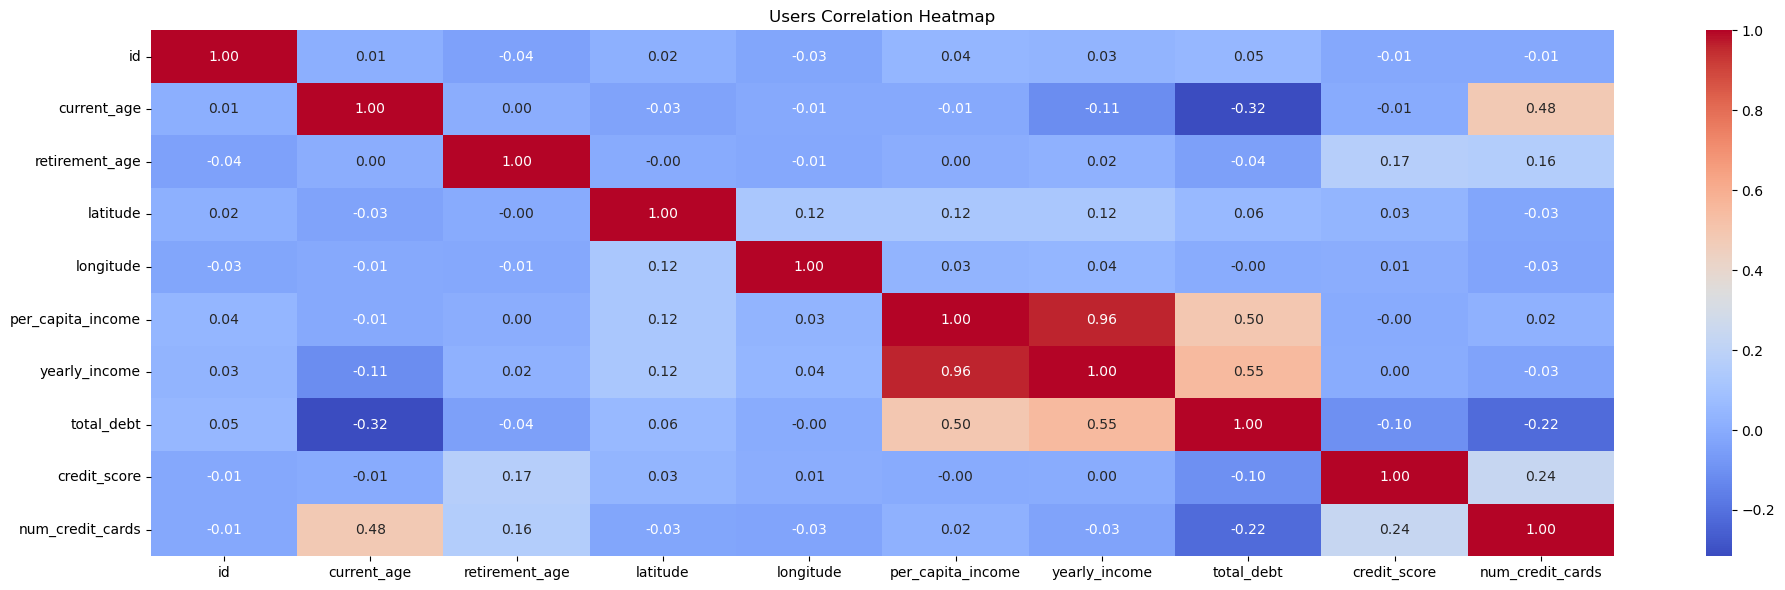

In [59]:
# Users Heatmap of correlation
num_df = users_df.select_dtypes(include='number')
corr = num_df.corr()
plt.figure(figsize=(20, 6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Users Correlation Heatmap')
plt.tight_layout()
plt.show()

<h4><b>Box Plots</h4>

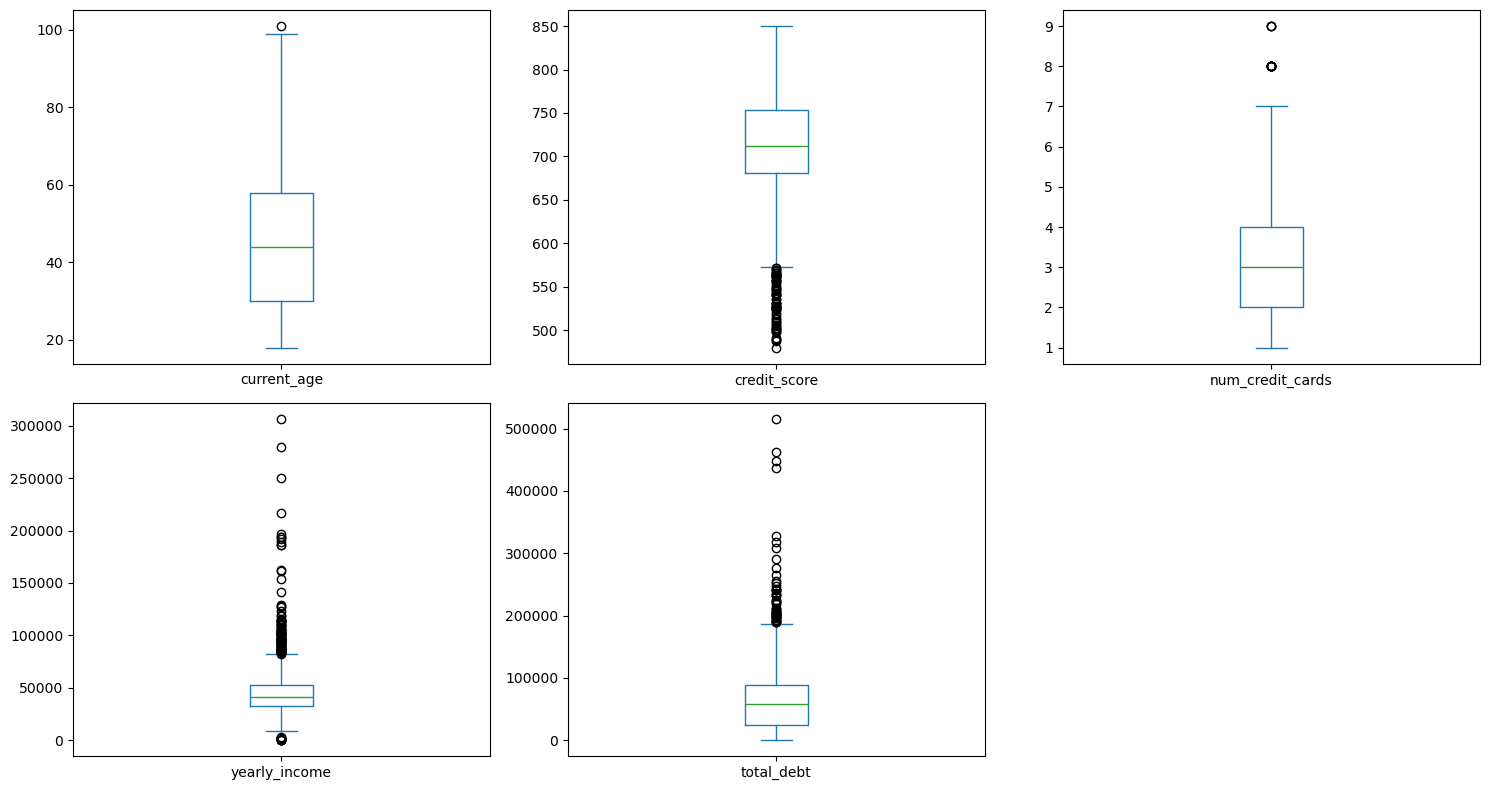

In [61]:
cols = ['current_age','credit_score','num_credit_cards','yearly_income','total_debt']
users_df[cols].plot(kind='box', subplots=True, layout=(2,3), figsize=(15,8), sharex=False, sharey=False)
plt.tight_layout()
plt.show()

<h4><b>Retirement Readiness & Targeting</h4>
Identify customers near retirement to market financial planning products.

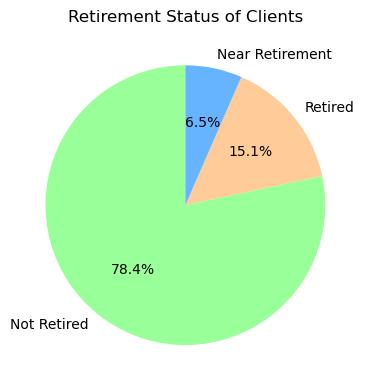

In [63]:
# Years left until retirement
users_df['years_to_retire'] = users_df['retirement_age'] - users_df['current_age']

# Classify Retirement
def classify_retirement(row):
    if row['current_age'] >= row['retirement_age']:
        return 'Retired'
    elif row['years_to_retire'] <= 5:
        return 'Near Retirement'
    else:
        return 'Not Retired'

users_df['retirement_status'] = users_df.apply(classify_retirement, axis=1)

# Plot 
plt.figure(figsize=(4,4))
users_df['retirement_status'].value_counts().plot.pie(
    autopct='%1.1f%%',
    colors=['#99ff99','#ffcc99','#66b3ff'], startangle=90)

plt.title('Retirement Status of Clients')
plt.ylabel('')
plt.tight_layout()
plt.show()

<h4><b>Regional Analysis Using Latitude & Longitude</h4>
Identify profitable or risky geographic areas.

In [65]:
# Simple quadrant segmentation
users_df['region'] = users_df.apply(
    lambda row: 
    'North' if row['latitude'] >= users_df['latitude'].median() and row['longitude'] < users_df['longitude'].median() else
    'South' if row['latitude'] < users_df['latitude'].median() and row['longitude'] < users_df['longitude'].median() else
    'East' if row['latitude'] >= users_df['latitude'].median() and row['longitude'] >= users_df['longitude'].median() else
    'West',
    axis=1
)

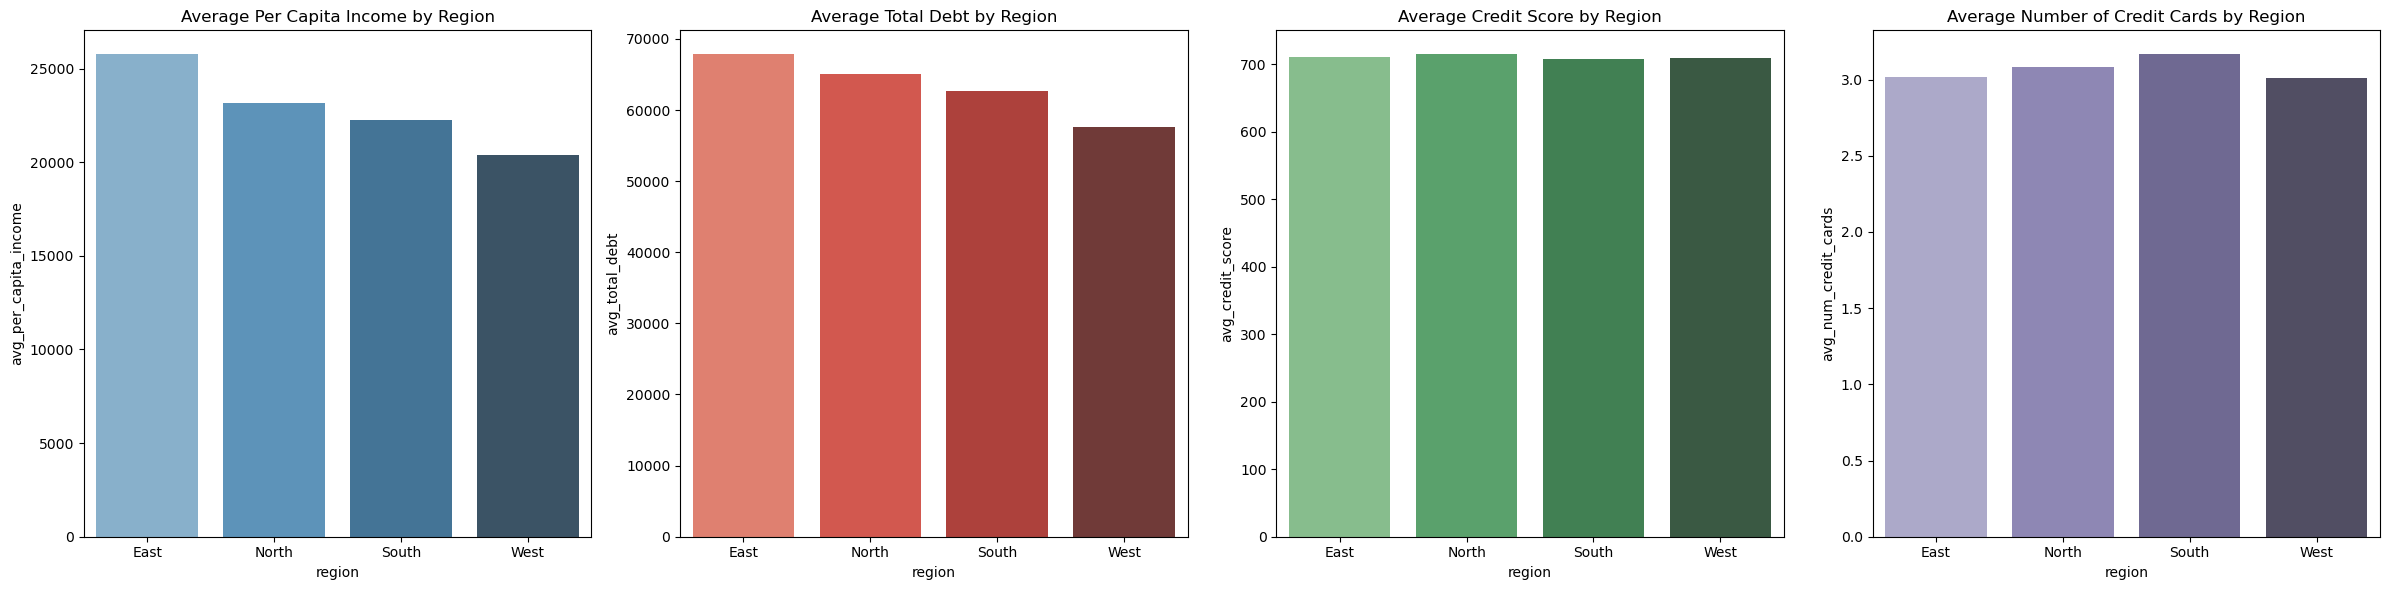

In [66]:
# Group by region to compute averages
region_summary = users_df.groupby('region').agg({
    'per_capita_income': 'mean',
    'total_debt': 'mean',
    'credit_score': 'mean',
    'num_credit_cards': 'mean'
}).reset_index()

region_summary.rename(columns={
    'per_capita_income': 'avg_per_capita_income',
    'total_debt': 'avg_total_debt',
    'credit_score': 'avg_credit_score',
    'num_credit_cards': 'avg_num_credit_cards'
}, inplace=True)

# Create 1 row × 4 columns of subplots
fig, axes = plt.subplots(1, 4, figsize=(24, 6))  # wider figure

sns.barplot(x='region', y='avg_per_capita_income', data=region_summary, ax=axes[0], palette='Blues_d')
axes[0].set_title('Average Per Capita Income by Region')

sns.barplot(x='region', y='avg_total_debt', data=region_summary, ax=axes[1], palette='Reds_d')
axes[1].set_title('Average Total Debt by Region')

sns.barplot(x='region', y='avg_credit_score', data=region_summary, ax=axes[2], palette='Greens_d')
axes[2].set_title('Average Credit Score by Region')

sns.barplot(x='region', y='avg_num_credit_cards', data=region_summary, ax=axes[3], palette='Purples_d')
axes[3].set_title('Average Number of Credit Cards by Region')

plt.tight_layout()
plt.show()

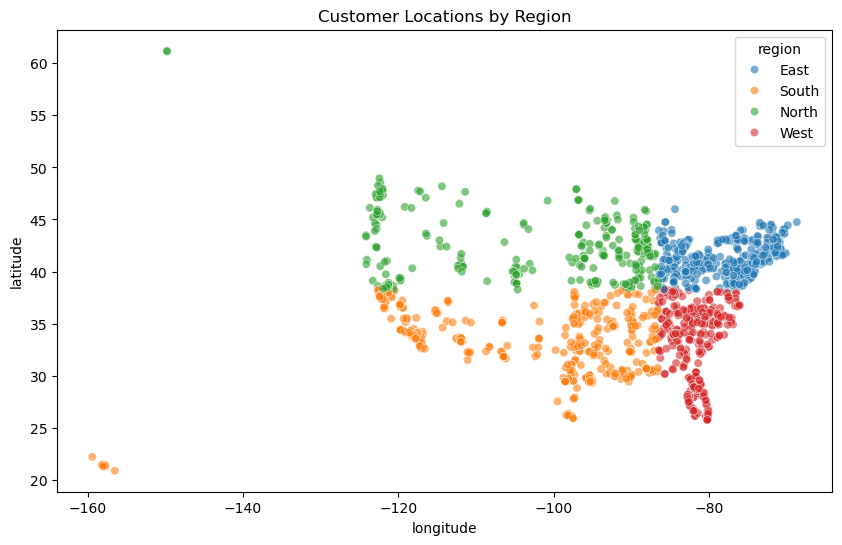

In [67]:
# scatter map
plt.figure(figsize=(10,6))
sns.scatterplot(x='longitude', y='latitude', hue='region', data=users_df, alpha=0.6)
plt.title('Customer Locations by Region')
plt.show()

<h4><b>Credit Risk Profiling</h4>
Detect high-risk customers for credit products or limit increases.

In [69]:
users_df['debt_to_income_ratio'] = users_df['total_debt'] / users_df['yearly_income']

# Segment customers
risk_segments = pd.cut(users_df['credit_score'], 
                       bins=[300,580,670,740,800,850],
                       labels=['Poor','Fair','Good','Very Good','Excellent'])

users_df['credit_segment'] = risk_segments

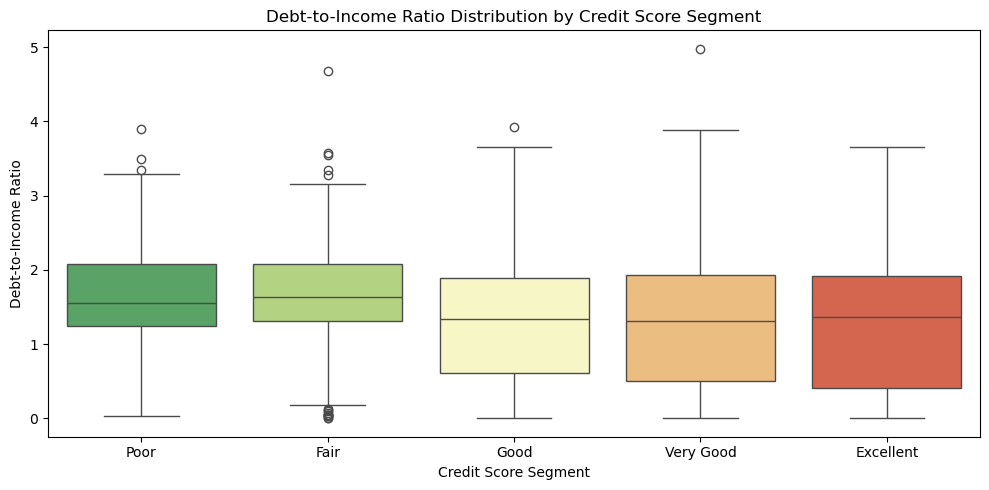

In [70]:
risk_order = ['Poor','Fair','Good','Very Good','Excellent']

plt.figure(figsize=(10,5))
sns.boxplot(
    x='credit_segment', y='debt_to_income_ratio', 
    data=users_df, order=risk_order, palette='RdYlGn_r')

plt.title('Debt-to-Income Ratio Distribution by Credit Score Segment')
plt.xlabel('Credit Score Segment')
plt.ylabel('Debt-to-Income Ratio')
plt.tight_layout()
plt.show()

<h4><b>Income Segmentation</h4>
Design premium products for high earners and budget solutions for low earners.

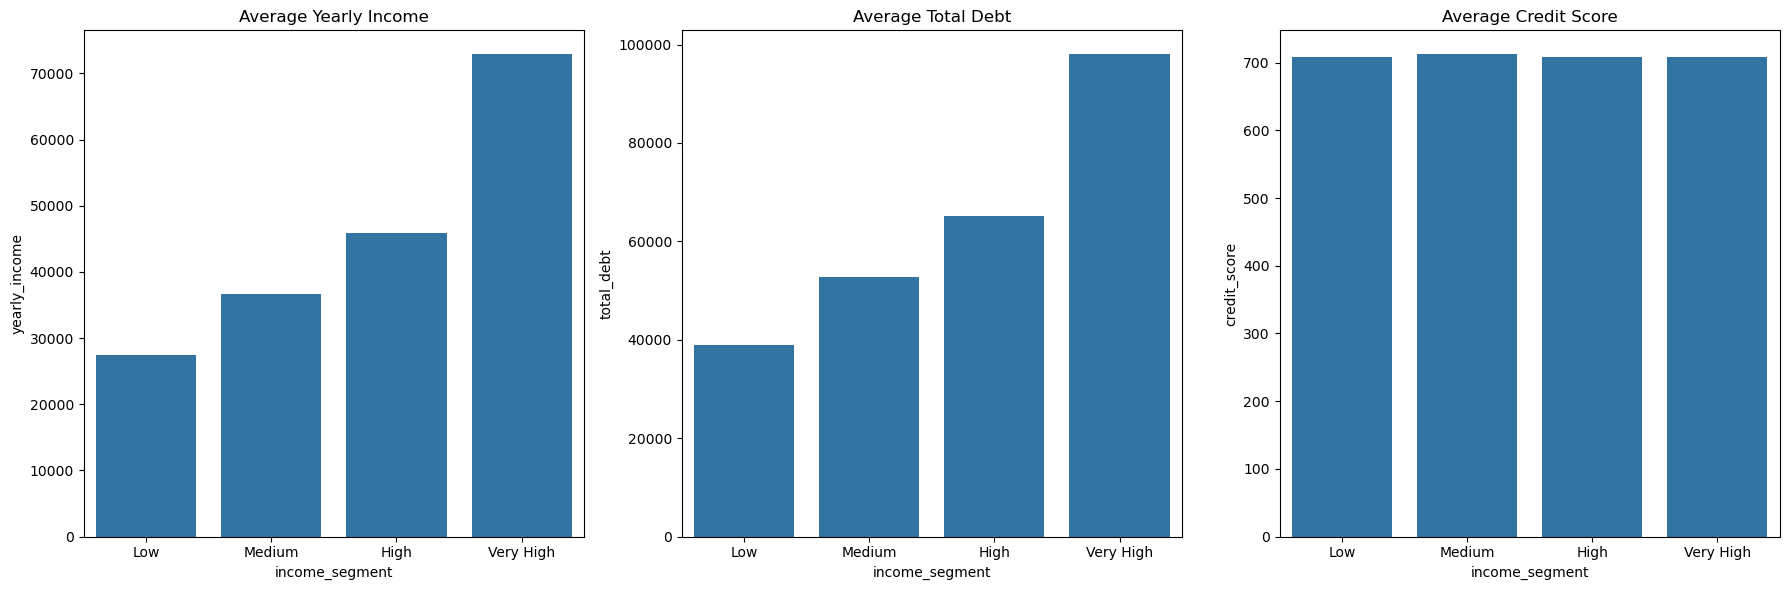

In [72]:
# Segment by per_capita_income
income_segments = pd.qcut(users_df['per_capita_income'], q=4, labels=['Low','Medium','High','Very High'])
users_df['income_segment'] = income_segments

income_summary = users_df.groupby('income_segment')[['yearly_income','total_debt','credit_score']].mean().reset_index()

fig, axes = plt.subplots(1,3, figsize=(18,6))

sns.barplot(x='income_segment', y='yearly_income', data=income_summary, ax=axes[0])
axes[0].set_title('Average Yearly Income')

sns.barplot(x='income_segment', y='total_debt', data=income_summary, ax=axes[1])
axes[1].set_title('Average Total Debt')

sns.barplot(x='income_segment', y='credit_score', data=income_summary, ax=axes[2])
axes[2].set_title('Average Credit Score')

plt.tight_layout()
plt.show()

<h4><b>Number of Credit Cards vs Income vs Credit Score</h4>
Shows which clients have high spending capacity but low credit scores

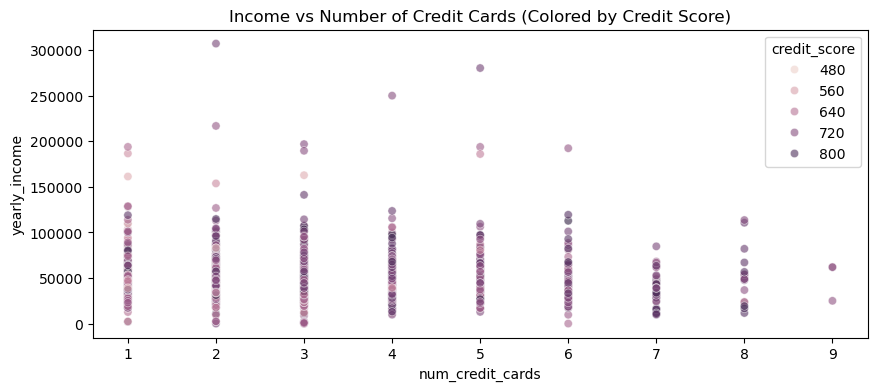

In [74]:
plt.figure(figsize=(10,4))
sns.scatterplot(x='num_credit_cards', y='yearly_income',
                hue='credit_score', data=users_df, alpha=0.6)
plt.title('Income vs Number of Credit Cards (Colored by Credit Score)')
plt.show()

<h4><b>Debt-to-Income Ratio vs. Credit Score & Retirement Age</h4>
Shows whether people nearing retirement are financially stressed (high debt but low credit score).

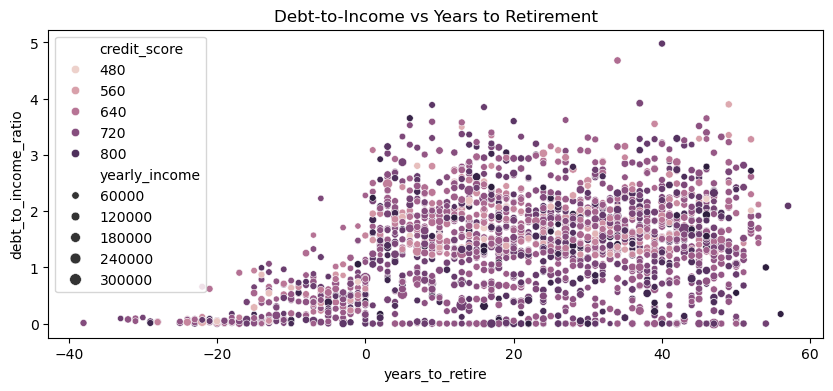

In [76]:
plt.figure(figsize=(10,4))
sns.scatterplot(x='years_to_retire', y='debt_to_income_ratio', hue='credit_score', size='yearly_income', data=users_df)
plt.title('Debt-to-Income vs Years to Retirement')
plt.show()

<h4><b>Debt by Credit Score Bands</h4>

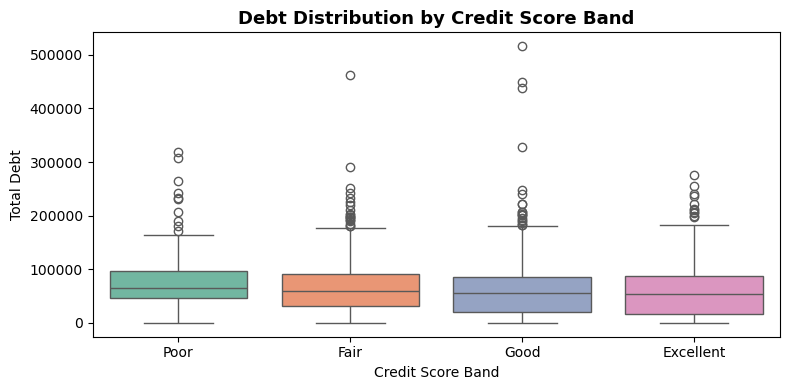

In [78]:
bins = [0,600,700,750,850]
labels = ['Poor','Fair','Good','Excellent']
users_df['score_band'] = pd.cut(users_df['credit_score'], bins=bins, labels=labels)

plt.figure(figsize=(8,4))
sns.boxplot(x='score_band', y='total_debt', data=users_df, palette='Set2')
plt.title('Debt Distribution by Credit Score Band', fontsize=13, weight='bold')
plt.xlabel('Credit Score Band'); plt.ylabel('Total Debt')
plt.tight_layout()
plt.show()

<h4><b>PCI vs Yearly Income Scatter</h4>

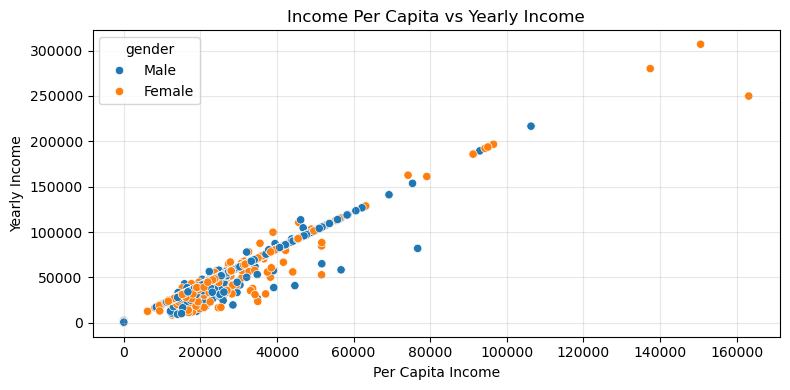

In [80]:
# PCI vs Yearly Income Scatter
plt.figure(figsize=(8,4))
sns.scatterplot(x='per_capita_income', y='yearly_income', data=users_df, hue='gender')
plt.title('Income Per Capita vs Yearly Income')
plt.xlabel('Per Capita Income')
plt.ylabel('Yearly Income')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [81]:
# Age Group
bins = [17, 24, 34, 44, 54, 64, 120] 
labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']

users_df['age_group'] = pd.cut(users_df['current_age'], bins=bins, labels=labels)

In [82]:
# Income Group
bins = [0, 30000, 60000, 100000, 200000, users_df['yearly_income'].max()]
labels = ['Low', 'Lower-Middle', 'Upper-Middle', 'High', 'Very High']

users_df['income_group'] = pd.cut(users_df['yearly_income'], bins=bins, labels=labels)

<h4><b>Transactions Data</h4>

<h4><b>Heatmap of correlation</h4>

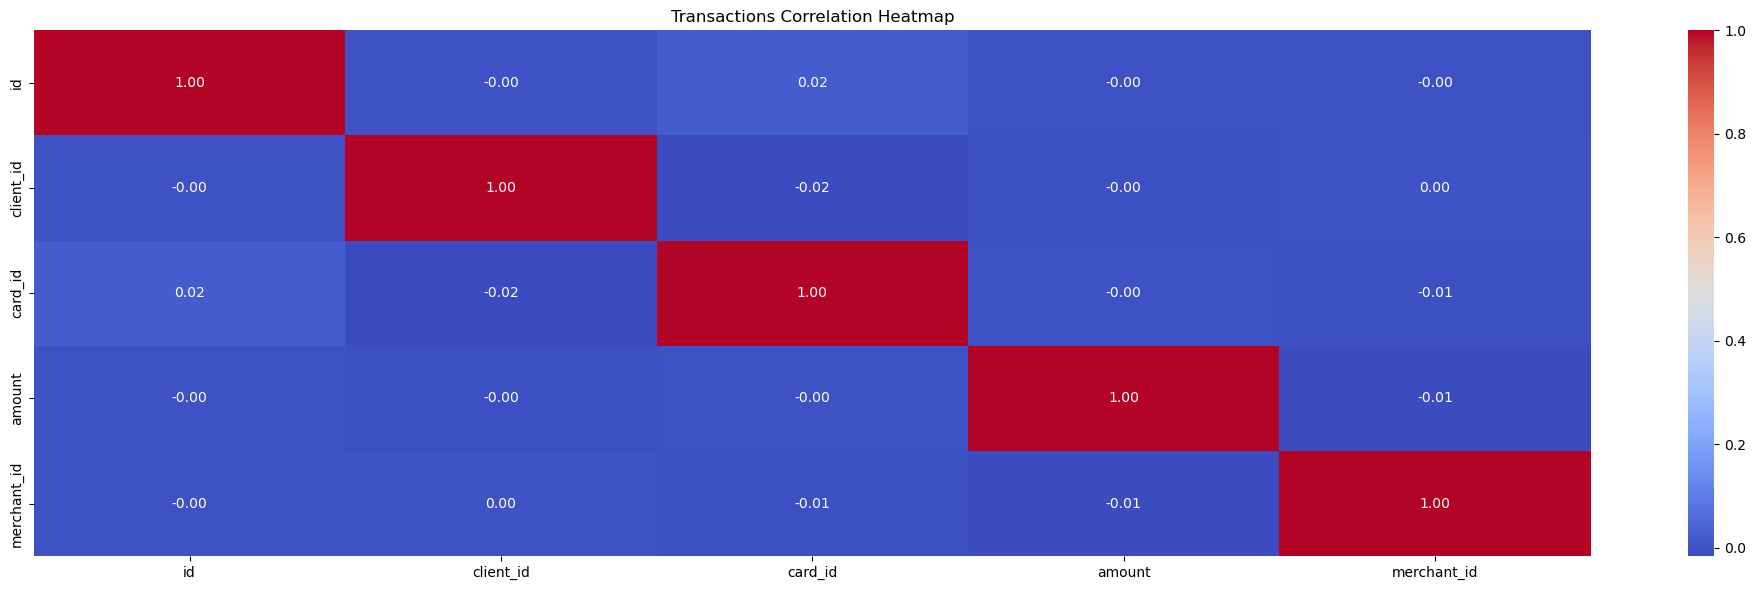

In [85]:
num_df = transactions_df.select_dtypes(include='number')
corr = num_df.corr()
plt.figure(figsize=(20, 6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Transactions Correlation Heatmap')
plt.tight_layout()
plt.show()

<h4><b>Box Plot Transactions Amount</h4>

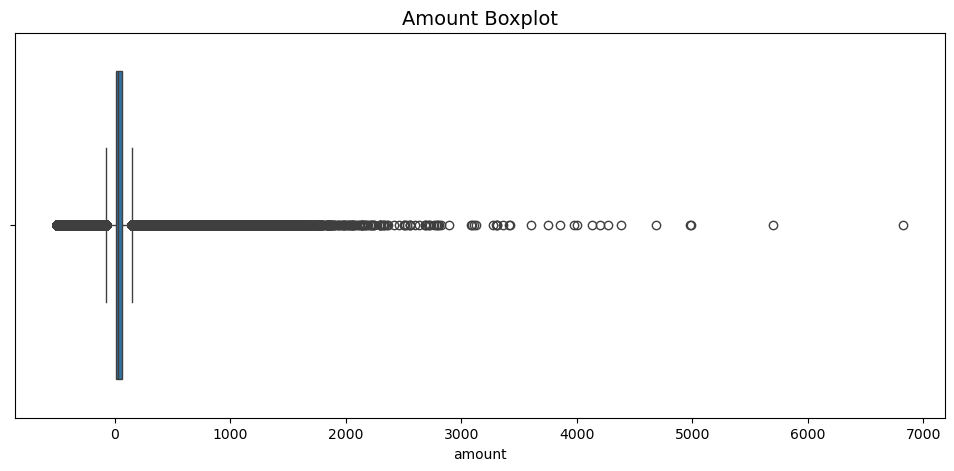

In [87]:
plt.figure(figsize=(12,5))
sns.boxplot(x=transactions_df['amount'])
plt.title('Amount Boxplot', fontsize=14)
plt.show()

<h4><b>Use Chip Distribution</h4>

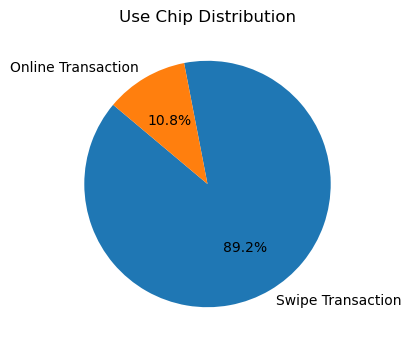

In [89]:
use_chip_counts = transactions_df['use_chip'].value_counts()
plt.figure(figsize=(4,4))
plt.pie(use_chip_counts, labels=use_chip_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Use Chip Distribution')
plt.show()

<h4><b>Trend Analysis</h4>

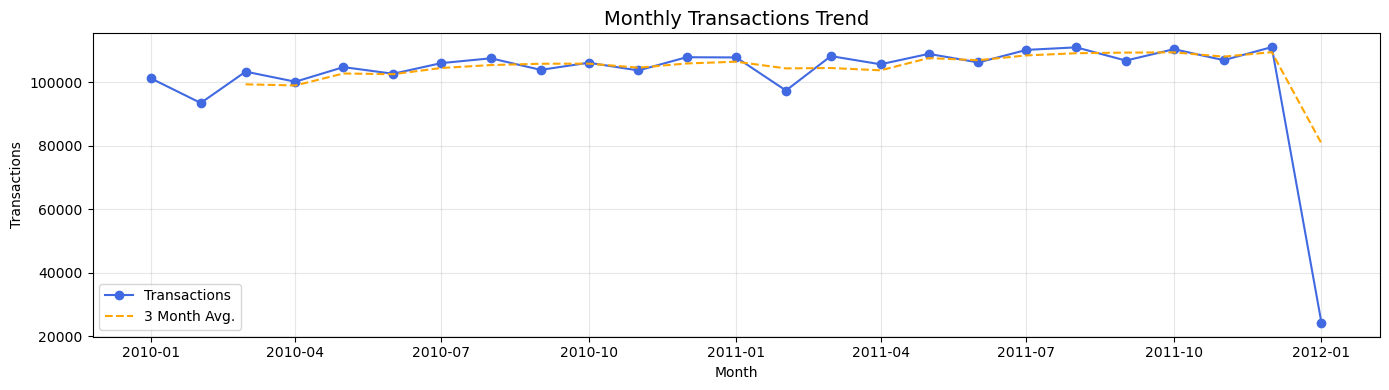

In [91]:
transactions_df['month'] = transactions_df['date'].dt.to_period('M').dt.to_timestamp()
monthly = transactions_df.groupby('month').size()

plt.figure(figsize=(14,4))
plt.plot(monthly.index, monthly.values, marker='o', color='royalblue', label='Transactions')
plt.plot(monthly.index, monthly.rolling(3).mean(), color='orange', linestyle='--', label='3 Month Avg.')
plt.title('Monthly Transactions Trend', fontsize=14)
plt.xlabel('Month'); plt.ylabel('Transactions'); plt.grid(alpha=0.3); plt.legend()
plt.tight_layout(); plt.show()

<h4><b>Customer Activity Rate (Active Clients)</h4>

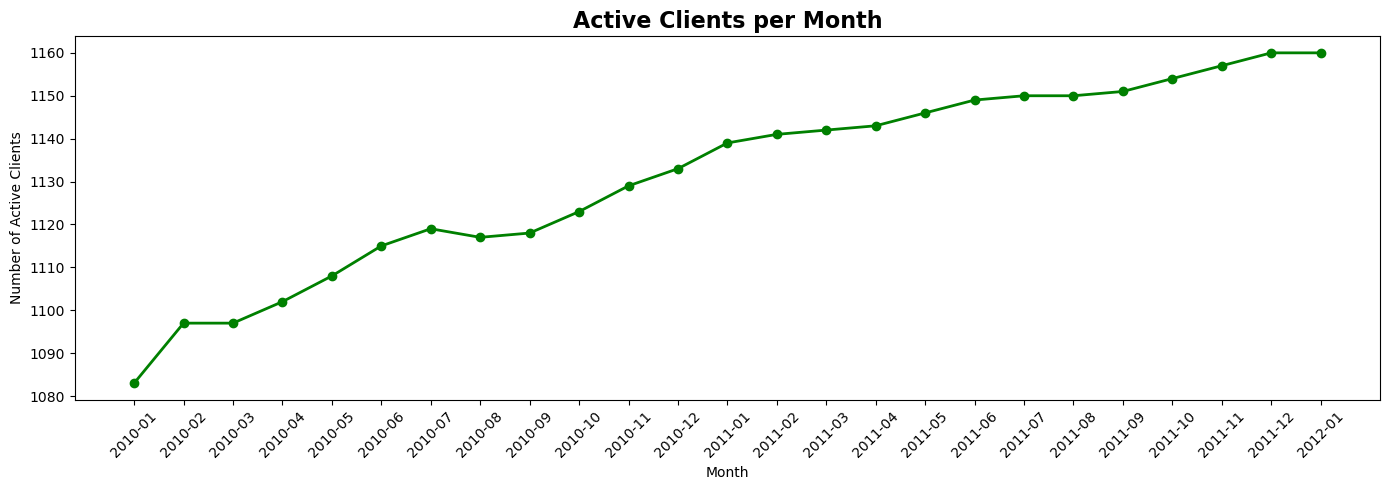

In [93]:
transactions_df['month'] = transactions_df['date'].dt.to_period('M')  
# Group by month to count unique clients
active_clients = transactions_df.groupby('month')['client_id'].nunique()

# Plot
plt.figure(figsize=(14,5))
plt.plot(active_clients.index.astype(str), active_clients.values, 
         marker='o', color='green', linewidth=2)
plt.title('Active Clients per Month', fontsize=16, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Number of Active Clients')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<h4><b>Average Ticket Size (ATS) (average spend per transaction over time)</h4>

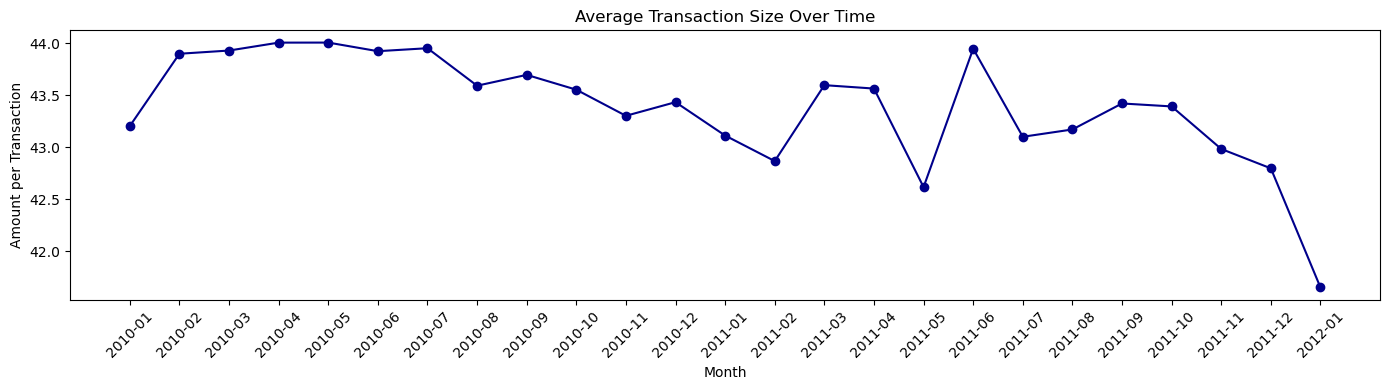

In [96]:
monthly_amount = transactions_df.groupby('month')['amount'].sum()
monthly_count  = transactions_df.groupby('month').size()
ats = monthly_amount / monthly_count

plt.figure(figsize=(14,4))
plt.plot(ats.index.astype(str), 
         ats.values, marker='o', color='darkblue')
plt.title('Average Transaction Size Over Time')
plt.ylabel('Amount per Transaction')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<h4><b>Transactions Heatmap by Day and Hour</h4>

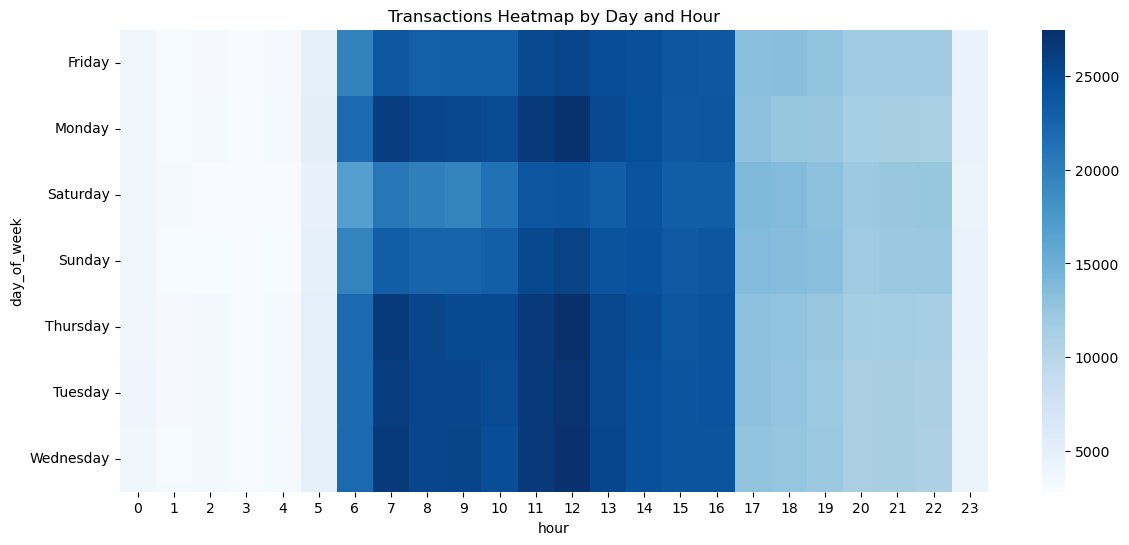

In [98]:
transactions_df['day_of_week'] = transactions_df['date'].dt.day_name()
transactions_df['hour'] = transactions_df['date'].dt.hour

heatmap_data = transactions_df.groupby(['day_of_week','hour']).size().unstack(fill_value=0)

plt.figure(figsize=(14,6))
sns.heatmap(heatmap_data, cmap='Blues')
plt.title('Transactions Heatmap by Day and Hour')
plt.show()

<h4><b>Top 5 Cities and States</h4>

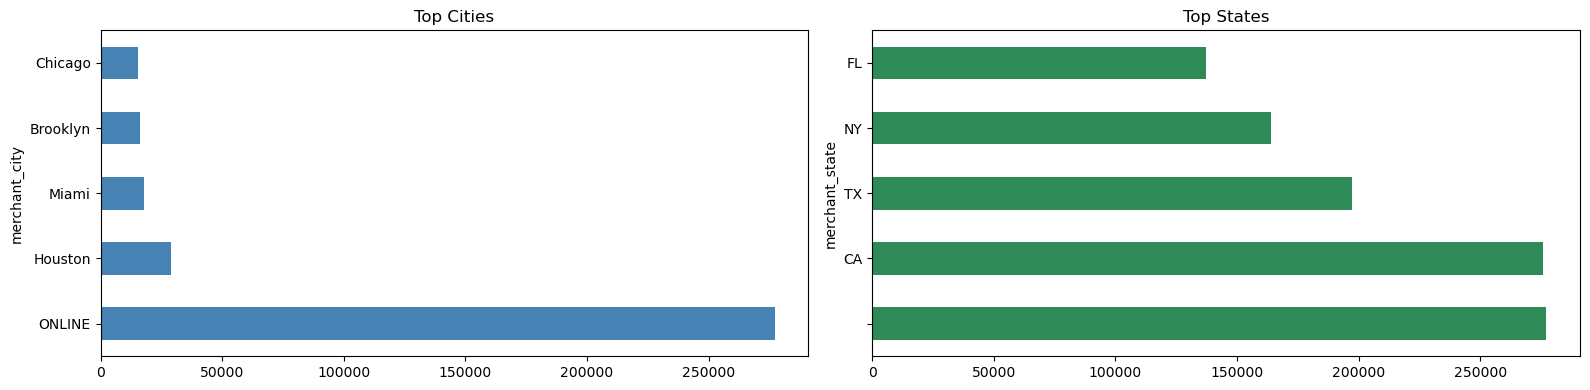

In [100]:
fig,ax=plt.subplots(1,2,figsize=(16,4))
transactions_df['merchant_city'].value_counts().head().plot(kind='barh',ax=ax[0],color='steelblue',title='Top Cities')
transactions_df['merchant_state'].value_counts().head().plot(kind='barh',ax=ax[1],color='seagreen',title='Top States')
plt.tight_layout();plt.show()

<h4><b>Amount vs MCC</h4>

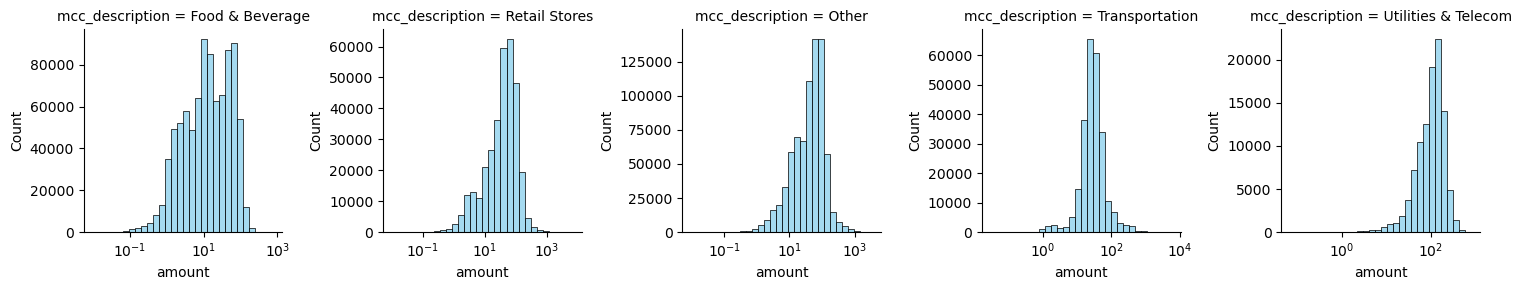

In [102]:
top_mcc = transactions_df['mcc_description'].value_counts().head().index.tolist()

g = sns.FacetGrid(
    transactions_df[transactions_df['mcc_description'].isin(top_mcc)],
    col='mcc_description', col_wrap=5, height=3, sharex=False, sharey=False
)
g.map(sns.histplot, 'amount', log_scale=True, bins=30, color='skyblue')
plt.tight_layout()
plt.show()

<h4><b>Cards Data</h4>

<h4><b>Heatmap of correlation</h4>

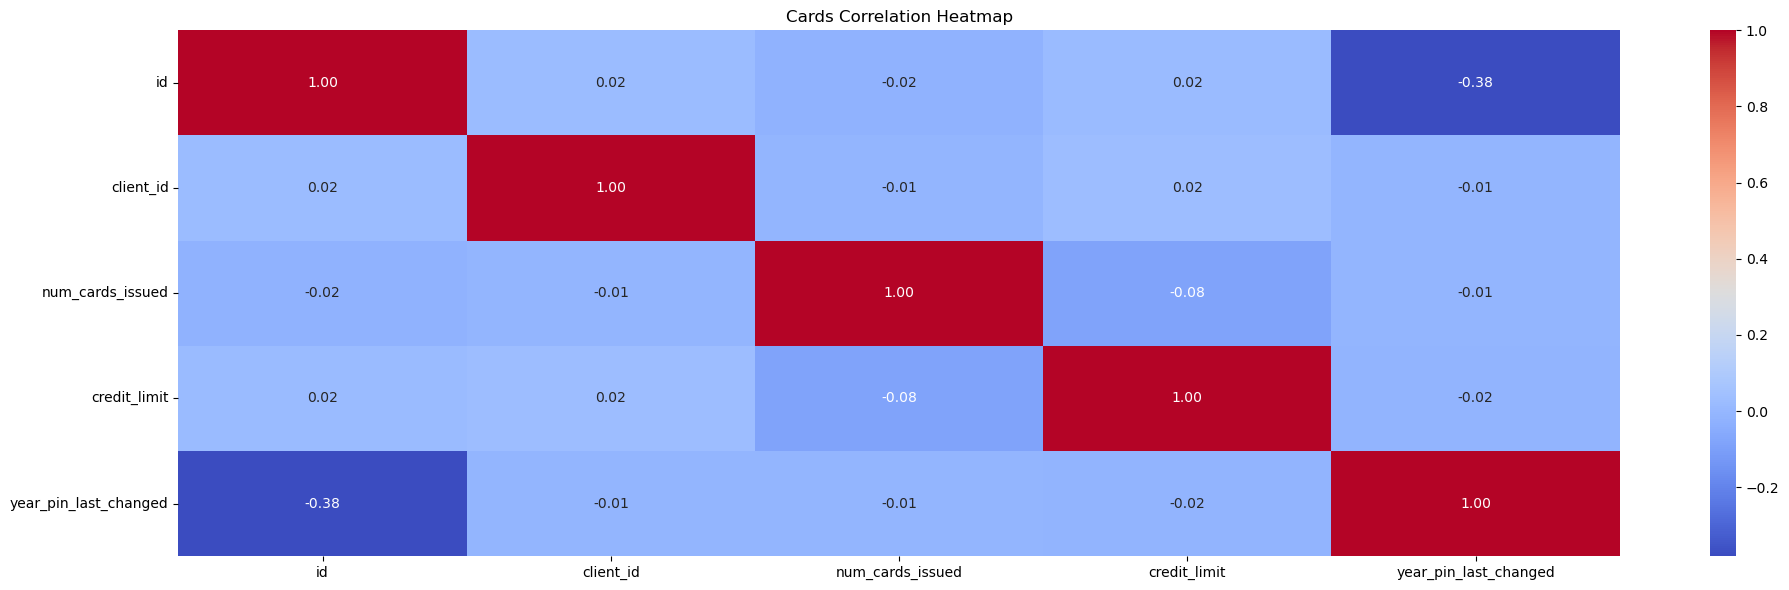

In [106]:
num_df = cards_df.select_dtypes(include='number')
corr = num_df.corr()
plt.figure(figsize=(20, 6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Cards Correlation Heatmap')
plt.tight_layout()
plt.show()

<h4><b>Card Brand & Type Distribution</h4>

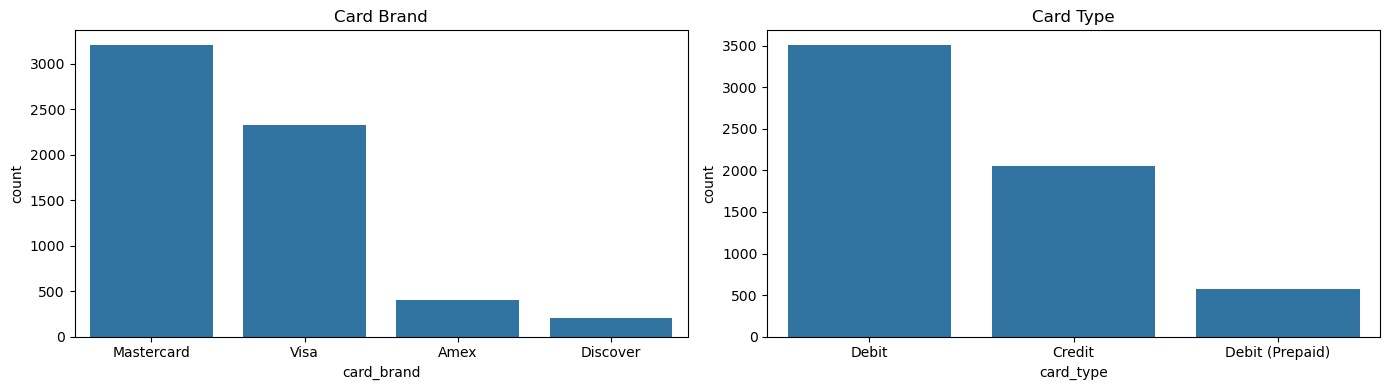

In [108]:
fig,ax=plt.subplots(1,2,figsize=(14,4))
sns.countplot(x='card_brand',data=cards_df,
              order=cards_df['card_brand'].value_counts().index,ax=ax[0])
ax[0].set_title('Card Brand')

sns.countplot(x='card_type',data=cards_df,
              order=cards_df['card_type'].value_counts().index,ax=ax[1])
ax[1].set_title('Card Type')

plt.tight_layout()
plt.show()

<h4><b>Average Credit Limit by Card Type / Brand</h4>

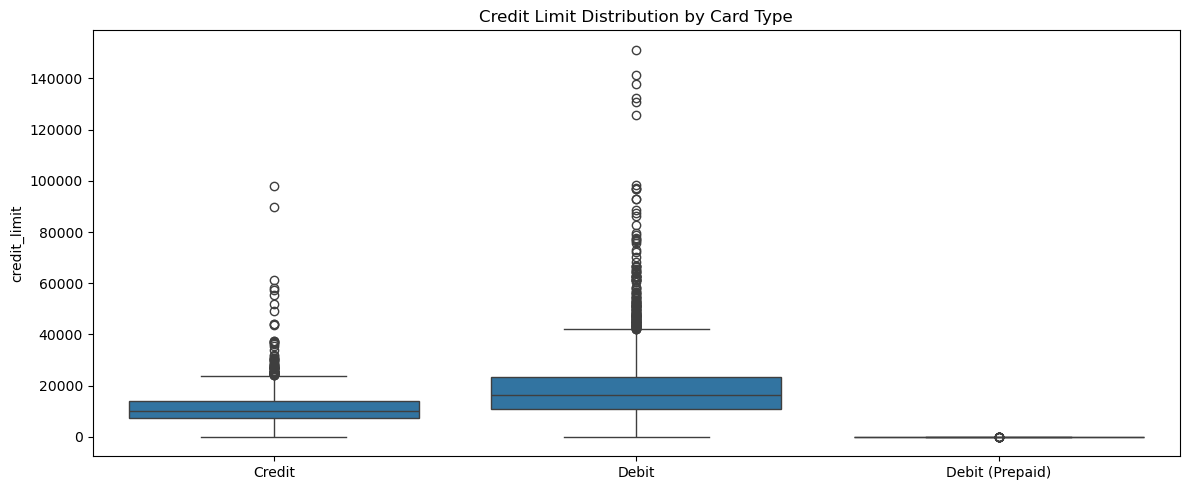

In [111]:
plt.figure(figsize=(12,5))
sns.boxplot(x='card_type', y='credit_limit', data=cards_df)
plt.title('Credit Limit Distribution by Card Type')
plt.xlabel('')
plt.tight_layout()
plt.show()

<h4><b>Customer Age with the Bank</h4>

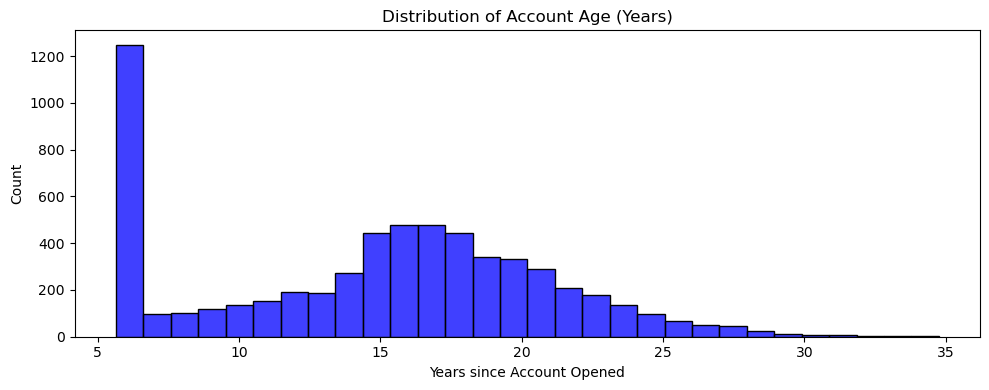

In [113]:
cards_df['acct_age_years'] = (pd.Timestamp.today() - cards_df['acct_open_date']).dt.days/365

plt.figure(figsize=(10,4))
sns.histplot(cards_df['acct_age_years'], bins=30, color='blue')
plt.title('Distribution of Account Age (Years)')
plt.xlabel('Years since Account Opened')
plt.tight_layout()
plt.show()

<h4><b>PIN Security Hygiene (Find customers who haven’t changed their PIN recently)</h4>

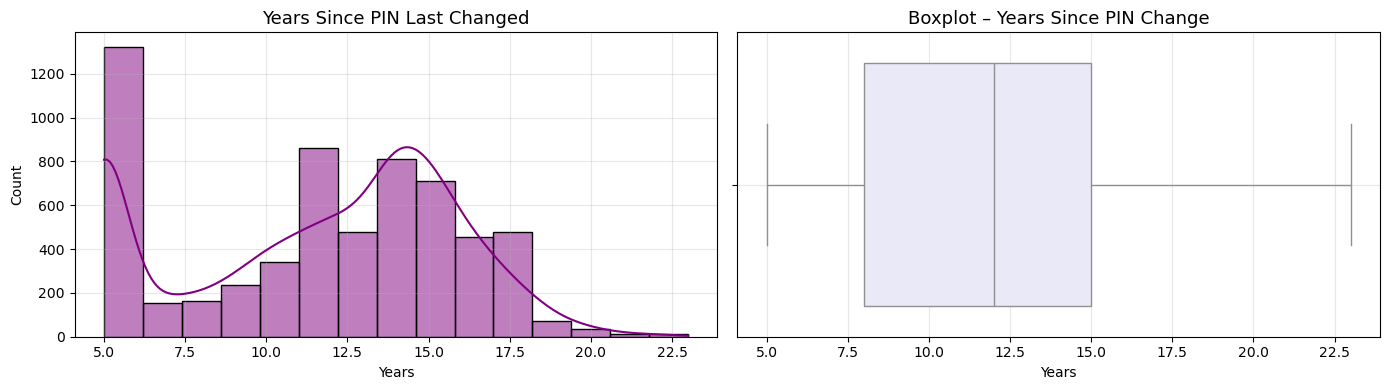

In [115]:
recent_year = pd.Timestamp.today().year
cards_df['years_since_pin_change'] = recent_year - cards_df['year_pin_last_changed']

fig, ax = plt.subplots(1,2,figsize=(14,4))

# KDE + histogram
sns.histplot(cards_df['years_since_pin_change'], bins=15, kde=True, color='purple', ax=ax[0])
ax[0].set_title('Years Since PIN Last Changed', fontsize=13)
ax[0].set_xlabel('Years')
ax[0].grid(alpha=0.3)

# Boxplot for quick outlier view
sns.boxplot(x=cards_df['years_since_pin_change'], color='lavender', ax=ax[1])
ax[1].set_title('Boxplot – Years Since PIN Change', fontsize=13)
ax[1].set_xlabel('Years')
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

<h4><b>Cards Per Customer</h4>

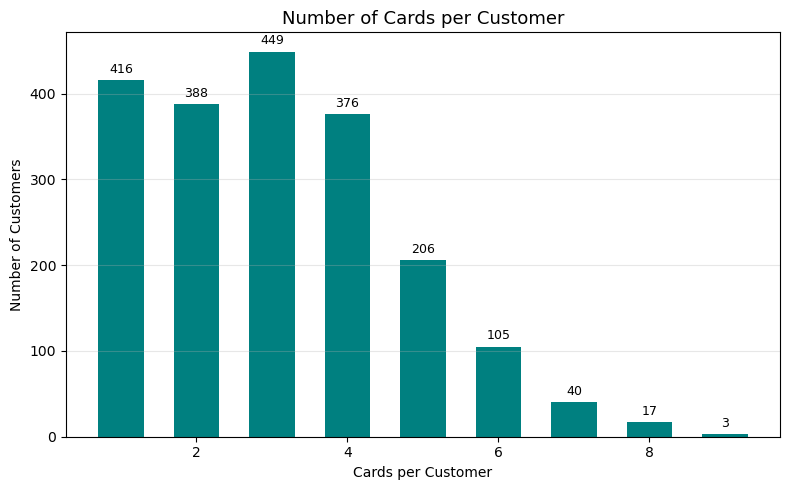

In [117]:
cards_per_client = cards_df.groupby('client_id')['num_cards_issued'].count()
cards_count = cards_per_client.value_counts().sort_index()

fig, ax = plt.subplots(figsize=(8,5))
bars = ax.bar(cards_count.index, cards_count.values, color='teal', width=0.6)
ax.set_title('Number of Cards per Customer', fontsize=13)
ax.set_xlabel('Cards per Customer')
ax.set_ylabel('Number of Customers')
ax.grid(axis='y', alpha=0.3)

for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()+5,
            f"{bar.get_height()}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

<h4><b>Expiring Cards</h4>

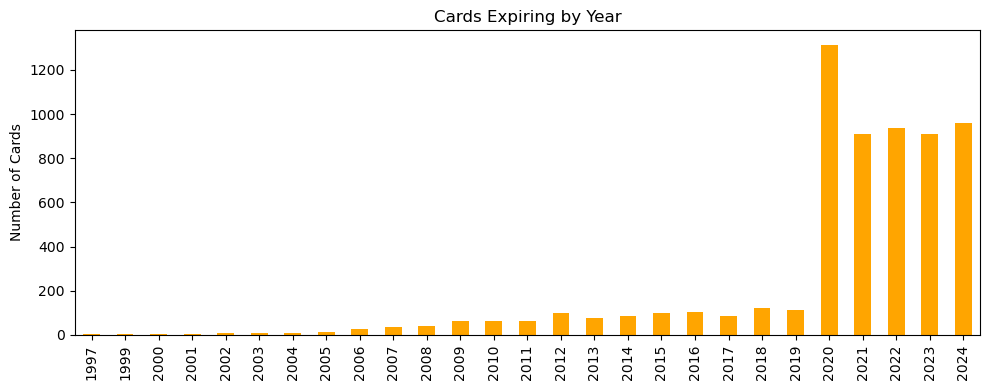

In [119]:
cards_df['expires_year'] = cards_df['expires'].dt.year
expiring = cards_df['expires_year'].value_counts().sort_index()

expiring.plot(kind='bar', figsize=(10,4), color='orange')
plt.title('Cards Expiring by Year')
plt.xlabel(''); plt.ylabel('Number of Cards')
plt.tight_layout()
plt.show()

<h4><b>Fraud Analysis</b></h4>

In [121]:
fraud_rate = transactions_df['fraud_label'].value_counts(normalize=True) * 100
print(fraud_rate)

fraud_label
No     99.897215
Yes     0.102785
Name: proportion, dtype: float64


<h4><b>Fraud by Transaction Amount</h4>

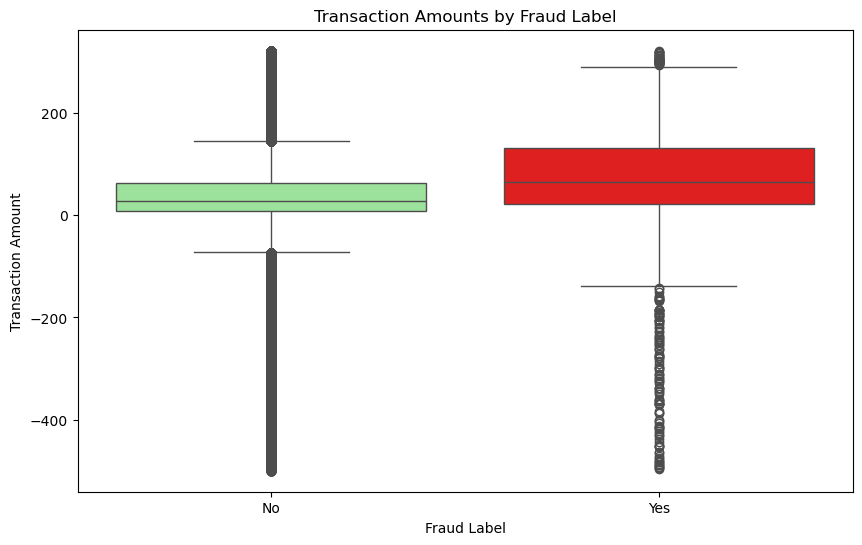

In [123]:
plt.figure(figsize=(10,6))
sns.boxplot(x='fraud_label', y='amount', data=transactions_df[transactions_df['amount'] < transactions_df['amount'].quantile(0.99)], palette=['lightgreen','red'])
plt.title('Transaction Amounts by Fraud Label')
plt.xlabel('Fraud Label')
plt.ylabel('Transaction Amount')
plt.show()

<h4><b>Fraud by Merchant City / State</h4>

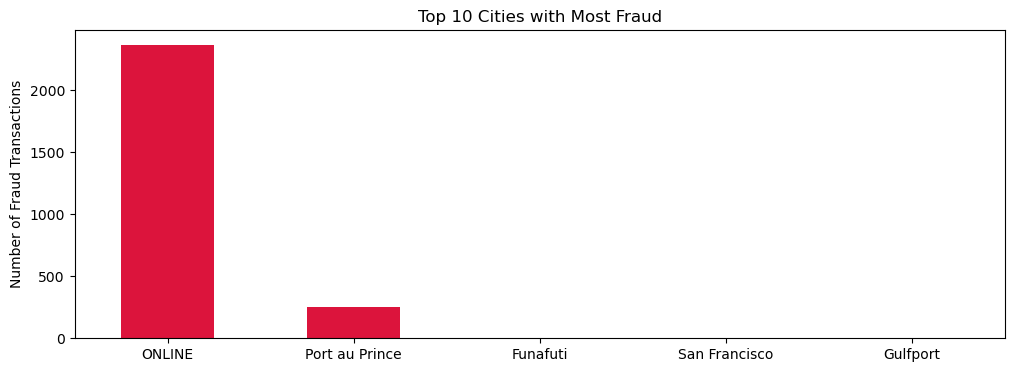

In [125]:
fraud_by_city = transactions_df[transactions_df['fraud_label']=='Yes']['merchant_city'].value_counts().head()

plt.figure(figsize=(12,4))
fraud_by_city.plot(kind='bar', color='crimson')
plt.title('Top 10 Cities with Most Fraud')
plt.xlabel('')
plt.ylabel('Number of Fraud Transactions')
plt.xticks(rotation=0)
plt.show()

<h4><b>Fraud by Merchant Category (MCC)</h4>

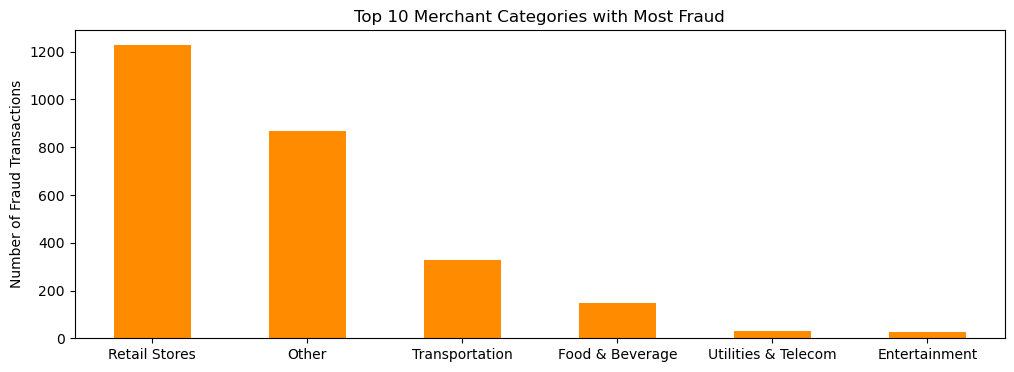

In [127]:
fraud_by_mcc = transactions_df[transactions_df['fraud_label']=='Yes']['mcc_description'].value_counts().head(6)

plt.figure(figsize=(12,4))
fraud_by_mcc.plot(kind='bar', color='darkorange')
plt.title('Top 10 Merchant Categories with Most Fraud')
plt.xlabel('')
plt.ylabel('Number of Fraud Transactions')
plt.xticks(rotation=0)
plt.show()

<h4><b>Fraud Amount Loss Estimation</h4>

In [129]:
fraud_loss = transactions_df.loc[transactions_df['fraud_label']=='Yes','amount'].sum()
total_loss = transactions_df['amount'].sum()

print(f"💰 Total Fraud Loss: ${fraud_loss:,.2f}")
print(f"⚠️ Fraud Loss Percentage: {fraud_loss/total_loss*100:.2f}%")

💰 Total Fraud Loss: $313,545.28
⚠️ Fraud Loss Percentage: 0.28%


<h4><b>Top 10 Clients Involved in Fraud (by count)</h4>

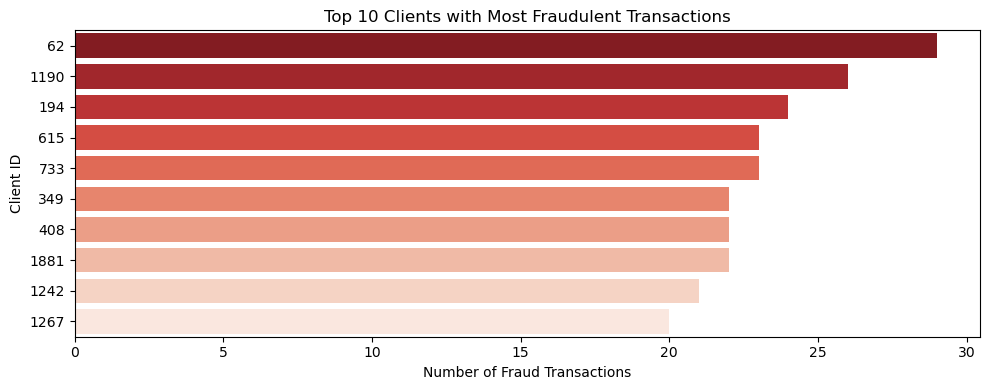

In [131]:
fraud_clients = (transactions_df[transactions_df['fraud_label'] == 'Yes']['client_id'].value_counts().head(10))

plt.figure(figsize=(10,4))
sns.barplot(
    x=fraud_clients.values,
    y=fraud_clients.index.astype(str),
    palette='Reds_r'
)
plt.title('Top 10 Clients with Most Fraudulent Transactions')
plt.xlabel('Number of Fraud Transactions')
plt.ylabel('Client ID')
plt.tight_layout()
plt.show()

<h4><b>Top 10 Merchants Involved in Fraud (by count)</h4>

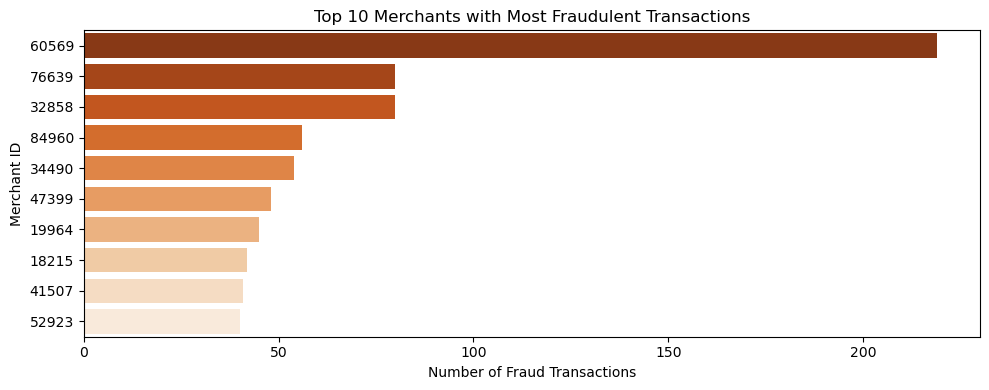

In [133]:
fraud_merchants = (transactions_df[transactions_df['fraud_label'] == 'Yes']['merchant_id'].value_counts().head(10))

plt.figure(figsize=(10,4))
sns.barplot(
    x=fraud_merchants.values,
    y=fraud_merchants.index.astype(str),
    palette='Oranges_r'
)
plt.title('Top 10 Merchants with Most Fraudulent Transactions')
plt.xlabel('Number of Fraud Transactions')
plt.ylabel('Merchant ID')
plt.tight_layout()
plt.show()

In [134]:
# Download the files 
users_df.to_csv('users_df.csv', index=False)
transactions_df.to_csv('transactions_df.csv', index=False)
cards_df.to_csv('cards_df.csv', index=False)